In [13]:
import pandas as pd
import numpy as np  

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [14]:
data = pd.read_csv('data.csv', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data = data.loc[:, (data != 0).any(axis=0)]

# Scale the Data

In [16]:
data = data/data.max()+1
data

,33,34,35,36,37,38,39,40,41,42,...,768,769,770,771,772,773,774,775,776,777
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Random Centroids Initialization

In [17]:
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis = 1)


In [18]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data-x) ** 2).sum(axis = 1)))
    return distances.idxmin(axis=1)

In [19]:
def new_centroids(data, labels, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x.mean()))).T

In [20]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x = data_2d[:,0], y = data_2d[:,1], c = labels)
    plt.scatter(x = centroids_2d[:,0], y = centroids_2d[:,1])
    plt.show()

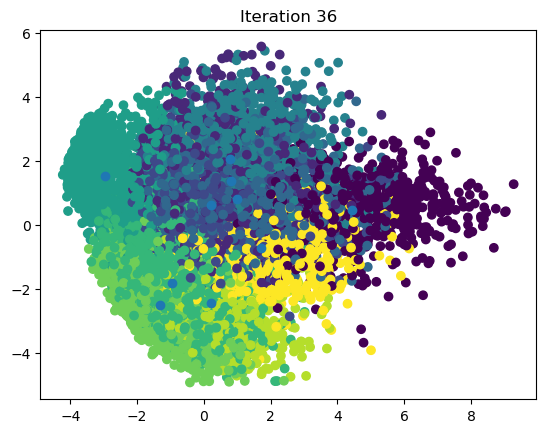

In [24]:
max_iterations = 1000
K = 10

centroids = random_centroids(data, K)
old_centroids = pd.DataFrame()
iteration = 1


while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids.copy()

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, K)
    plot_clusters(data, labels, centroids, iteration)
    iteration +=1

In [ ]:
kmeans_euclidean = labels.copy()

In [ ]:
def calculate_sse(data, centroids, labels):
    sse = 0

    for i in range(len(data)):
        
        cluster_center = centroids[labels[i]]
        sse += np.sum((data.iloc[i] - cluster_center) ** 2)
    return sse

In [ ]:
Euclidean_SSE = calculate_sse(data, centroids, labels)
Euclidean_SSE = Euclidean_SSE.round(2)

Euclidean_SSE


389475.04

In [ ]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: 1 - (data.dot(x) / (np.linalg.norm(data, axis=1) * np.linalg.norm(x))))
    return distances.idxmin(axis=1)

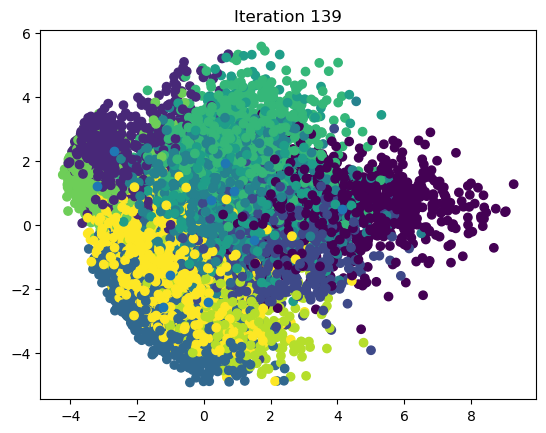

In [ ]:
max_iterations = 1000
K = 10

centroids = random_centroids(data, K)
old_centroids = pd.DataFrame()
iteration = 1


while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, K)
    plot_clusters(data, labels, centroids, iteration)
    iteration +=1

In [ ]:
kmeans_cosine = labels.copy()

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

def calculate_sse_cosine(data, centroids, labels):
    sse = 0

    for i in range(len(data)):
        cluster_center = centroids[labels[i]]
        
        cosine_sim = cosine_similarity(data.iloc[i], cluster_center)
        
        cosine_distance = 1 - cosine_sim
        
        sse += cosine_distance ** 2

    return sse

In [ ]:
Cosine_SSE = calculate_sse_cosine(data, centroids, labels)
Cosine_SSE = Cosine_SSE.round(2)

Cosine_SSE

4.12

In [ ]:
def generalized_jaccard_distance(x, y):
    intersection = np.sum(np.minimum(x, y))
    union = np.sum(np.maximum(x, y))
    
    return 1 - (intersection / union)


def get_labels(data, centroids):
    distances = centroids.apply(lambda centroid: data.apply(lambda point: generalized_jaccard_distance(centroid, point), axis=1))
    return distances.idxmin(axis=1)

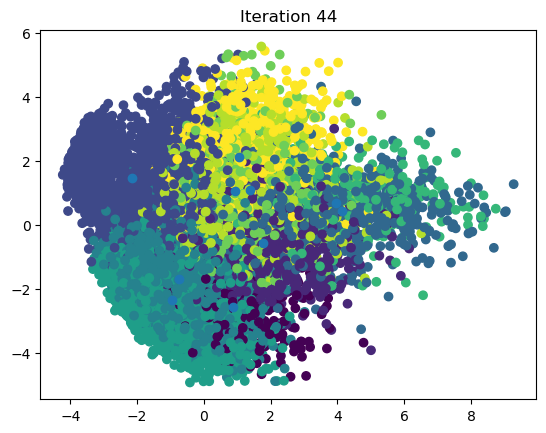

In [ ]:
max_iterations = 1000
K = 10

centroids = random_centroids(data, K)
old_centroids = pd.DataFrame()
iteration = 1


while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, K)
    plot_clusters(data, labels, centroids, iteration)
    iteration +=1

In [ ]:
def calculate_sse_jaccard(data, centroids, labels):
    sse = 0

    for i in range(len(data)):
        cluster_center = centroids[labels[i]]
        

        intersection = np.sum(np.minimum(data.iloc[i], cluster_center))
        union = np.sum(np.maximum(data.iloc[i], cluster_center))
        jaccard_distance = 1 - (intersection / union)
        
        sse += jaccard_distance

    return sse


In [ ]:
Jaccard_SSE = calculate_sse_jaccard(data, centroids, labels)
Jaccard_SSE = Jaccard_SSE.round(2)

Jaccard_SSE


1112.57

In [ ]:
kmeans_jaccard = labels.copy()

In [ ]:
models = pd.DataFrame({
    'Distance': [
        'Euclidean', 'Cosine', 'Jaccard'
    ],
    'SSE': [Euclidean_SSE, Cosine_SSE, Jaccard_SSE]})
models.sort_values(by='SSE', ascending=True)

,Distance,SSE
1,Cosine,4.12
2,Jaccard,1112.57
0,Euclidean,390807.78


In [ ]:
from sklearn.metrics import accuracy_score 


true_labels = pd.read_csv('label.csv', header=None)[0]
def majority_vote_labels(labels, true_labels):
    unique_clusters = set(labels)
    cluster_majority_votes = {cluster: max(set(true_labels[labels == cluster]), key=list(true_labels[labels == cluster]).count)
                              for cluster in unique_clusters}
    return [cluster_majority_votes[label] for label in labels]

labels_euclidean = majority_vote_labels(kmeans_euclidean, true_labels)
labels_cosine = majority_vote_labels(kmeans_cosine, true_labels)
labels_jaccard = majority_vote_labels(kmeans_jaccard, true_labels)

accuracy_euclidean = accuracy_score(true_labels, labels_euclidean)
accuracy_cosine = accuracy_score(true_labels, labels_cosine)
accuracy_jaccard = accuracy_score(true_labels, labels_jaccard)

In [ ]:
print(f"Euclidean-K-means Accuracy: {accuracy_euclidean}")
print(f"Cosine-K-means Accuracy: {accuracy_cosine}")
print(f"Jaccard-K-means Accuracy: {accuracy_jaccard}")

Euclidean-K-means Accuracy: 0.5942
Cosine-K-means Accuracy: 0.6011
Jaccard-K-means Accuracy: 0.5293
